In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6"})

# Time series analyses

## Data processing

Data was extracted from the Rijkswaterstaat's data register, and it corresponds to traffic jams on the main road network, from https://maps.rijkswaterstaat.nl/dataregister/srv/dut/catalog.search#/metadata/44105a01-0c81-440c-9adb-98c25ec1cc92

There is data from 2015 onwards, but a big inconvenience is that there is a separate file for every month. We were forced to scrape each individual file and then concatenate them. The data is adequately formatted, we were able to easily filter by only jams caused by high traffic intensity (so no accidents, road work, or other causes). Data is however too detailed for our purpose, so we are forced to drop data that is not useful, and aggregate the rest.

Data for 2020 was dropped because it is very distorted by the COVID-19 pandemic, and thus not representative of the overall patterns.

In [2]:
dfs = []

years = [str(year) for year in range(2015, 2020)]
# 2020 data looks too small, impact of COVID, distorsion in the data
months = [str(month).zfill(2) for month in range (1, 13)]

year_list = []
month_list = []
index_list = []

for year in years:
    for month in months:
        year_list.append(year)
        month_list.append(month)
        index_list.append(f"{year}-{month}")
        
        path = f"raw/{year}-{month}_rws_filedata.csv"
        df = pd.read_csv(path, sep=';')
        df = df[df['Oorzaak_4'] == 'Hoge intensiteit']
        df = df[['NLSitNummer']]
        df['year'] = year
        df['month'] = month
        df['yyyy-mm'] = f"{year}-{month}"
        dfs.append(df)
dfs[0]

,NLSitNummer,year,month,yyyy-mm
0,1698005,2015,01,2015-01
1,1698932,2015,01,2015-01
3,1698944,2015,01,2015-01
4,1698968,2015,01,2015-01
5,1697811,2015,01,2015-01
...,...,...,...,...
9140,1701544,2015,01,2015-01
9141,1696964,2015,01,2015-01
9142,1697938,2015,01,2015-01
9143,1697353,2015,01,2015-01


In [3]:
all_years = pd.concat(dfs)
traffic_jams_quantities = all_years.groupby(['year', 'month']).size()
#traffic_jams_df.columns(['year', 'month', 'quantity'])
jams_list = list(traffic_jams_quantities)

In [4]:
# data = [year_list, month_list, jams_list]
data = {'year': year_list, 'month': month_list, 'n_jams': jams_list}
traffic_jams_df = pd.DataFrame(data, index = index_list)
traffic_jams_df.tail(24)

traffic_jams_df.to_csv('processed/traffic_jams.csv')

## Data analysis

We can very quickly identify some seasonality in the data, where patterns are repeated every year.

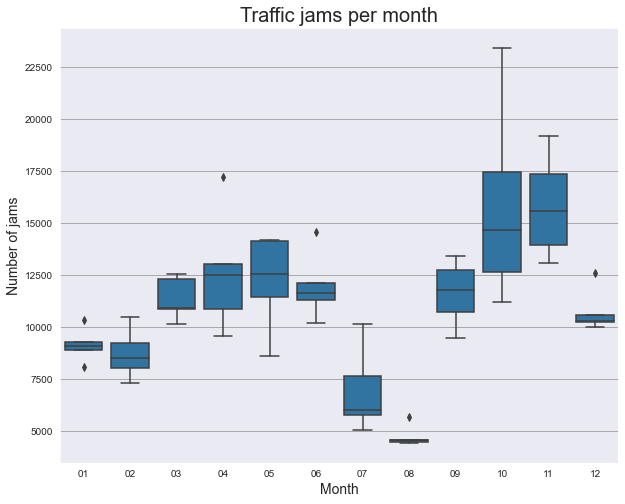

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

sns.boxplot(x="month", y="n_jams", data=traffic_jams_df, ax=ax, color="C0")
ax.set_title('Traffic jams per month', fontsize=20)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)

fig.savefig('figures/Boxplot_per_month.png')

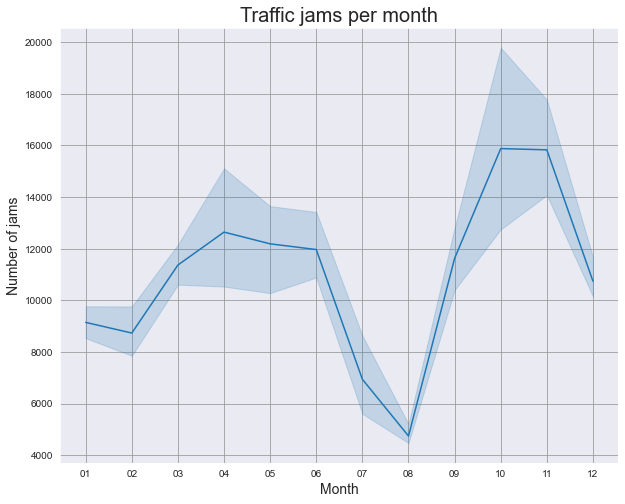

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

sns.lineplot(data=traffic_jams_df, x='month', y="n_jams", ax=ax)
ax.set_title('Traffic jams per month', fontsize=20)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)

fig.savefig('figures/Lineplot_per_month.png')

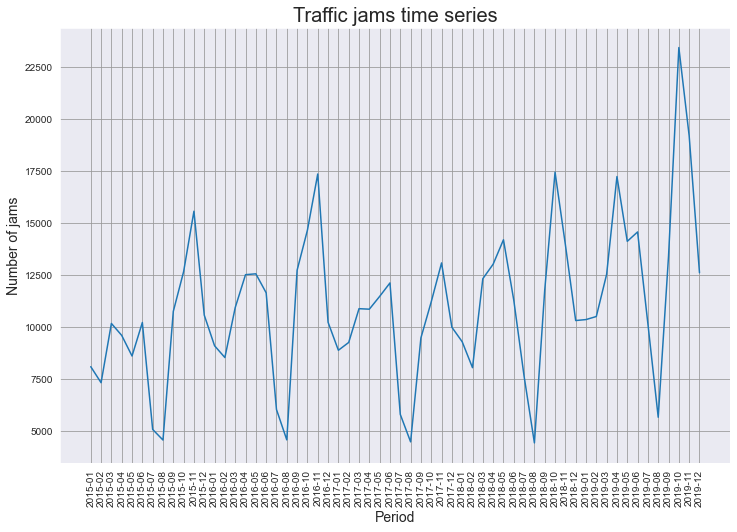

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

sns.lineplot(data=traffic_jams_df.reset_index(), x='index', y="n_jams", ax=ax)
ax.set_title('Traffic jams time series', fontsize=20)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)
ax.set_xticklabels(traffic_jams_df.reset_index()['index'], rotation = 90)

fig.savefig('figures/Time_series.png')

In [8]:
descriptive_month_df = traffic_jams_df.groupby(by='month').mean()
descriptive_month_df.rename(columns={'n_jams':'mean'}, inplace=True)
descriptive_month_df['std'] = traffic_jams_df.groupby(by='month').std()['n_jams']
descriptive_month_df['median'] = traffic_jams_df.groupby(by='month').median()['n_jams'].apply(lambda x: int(x))
descriptive_month_df['min'] = traffic_jams_df.groupby(by='month').min()['n_jams']
descriptive_month_df['max'] = traffic_jams_df.groupby(by='month').max()['n_jams']
descriptive_month_df = descriptive_month_df.round(3)

descriptive_month_df.to_csv('processed/descriptive_month.csv')

descriptive_month_df

,mean,std,median,min,max
month,,,,,
01,9146.4,816.798,9100,8095,10359
02,8734.2,1215.819,8534,7325,10506
03,11368.6,1015.515,10933,10172,12533
04,12644.4,2901.098,12516,9598,17231
05,12190.0,2302.980,12558,8608,14194
06,11968.8,1613.898,11645,10218,14570
07,6941.2,2023.305,6037,5080,10153
08,4745.6,517.573,4570,4432,5665
09,11628.0,1563.475,11776,9479,13404


## Single moving average

In [9]:
descriptive_year_df = traffic_jams_df.groupby(by='year').mean()
descriptive_year_df.rename(columns={'n_jams':'mean'}, inplace=True)
descriptive_year_df['std'] = traffic_jams_df.groupby(by='month').std()['n_jams']
descriptive_year_df['median'] = traffic_jams_df.groupby(by='month').median()['n_jams'].apply(lambda x: int(x))
descriptive_year_df['min'] = traffic_jams_df.groupby(by='month').min()['n_jams']
descriptive_year_df['max'] = traffic_jams_df.groupby(by='month').max()['n_jams']
descriptive_year_df = descriptive_month_df.round(3)

descriptive_year_df.to_csv('processed/descriptive_year.csv')

descriptive_year_df

,mean,std,median,min,max
month,,,,,
01,9146.4,816.798,9100,8095,10359
02,8734.2,1215.819,8534,7325,10506
03,11368.6,1015.515,10933,10172,12533
04,12644.4,2901.098,12516,9598,17231
05,12190.0,2302.980,12558,8608,14194
06,11968.8,1613.898,11645,10218,14570
07,6941.2,2023.305,6037,5080,10153
08,4745.6,517.573,4570,4432,5665
09,11628.0,1563.475,11776,9479,13404


In [10]:
# Test moving average

numbers = [9,8,9,12,9,12,11,7,13,9,11, 10]

data = {'X': numbers}
test_df = pd.DataFrame(data)

test_df['MA(3)'] = test_df.rolling(3, center=True).mean()['X']
test_df['Error'] = test_df['MA(3)'] - test_df['X']
test_df['Error squared'] = test_df['Error']**2
error = test_df['Error squared'].sum()
print(f'The sum of the squared errors is {error}')
test_df

The sum of the squared errors is 38.88888888888889


,X,MA(3),Error,Error squared
0,9,NaN,NaN,NaN
1,8,8.666667,0.666667,0.444444
2,9,9.666667,0.666667,0.444444
3,12,10.000000,-2.000000,4.000000
4,9,11.000000,2.000000,4.000000
5,12,10.666667,-1.333333,1.777778
6,11,10.000000,-1.000000,1.000000
7,7,10.333333,3.333333,11.111111
8,13,9.666667,-3.333333,11.111111
9,9,11.000000,2.000000,4.000000


In [11]:
# Test moving average

numbers = [9,8,9,12,9,12,11,7,13,9,11, 10]

data = {'X': numbers}
test_df = pd.DataFrame(data)

test_df['MA(4) intermediate'] = test_df.rolling(4, center=True).mean()['X']
test_df['MA(4)'] = test_df.rolling(2).mean()['MA(4) intermediate']
test_df['MA(4)'] = test_df['MA(4)'].shift(-1)
test_df['Error'] = test_df['MA(4)'] - test_df['X']
test_df['Error squared'] = test_df['Error']**2
error = test_df['Error squared'].sum()
print(f'The sum of the squared errors is {error}')
test_df

The sum of the squared errors is 32.796875


,X,MA(4) intermediate,MA(4),Error,Error squared
0,9,NaN,NaN,NaN,NaN
1,8,NaN,NaN,NaN,NaN
2,9,9.50,9.500,0.500,0.250000
3,12,9.50,10.000,-2.000,4.000000
4,9,10.50,10.750,1.750,3.062500
5,12,11.00,10.375,-1.625,2.640625
6,11,9.75,10.250,-0.750,0.562500
7,7,10.75,10.375,3.375,11.390625
8,13,10.00,10.000,-3.000,9.000000
9,9,10.00,10.375,1.375,1.890625


In [12]:
single_ma2_df = traffic_jams_df.copy()

single_ma2_df['MA(2) intermediate'] = single_ma2_df.rolling(2, center=True).mean()['n_jams']
single_ma2_df['MA(2)'] = single_ma2_df.rolling(2).mean()['MA(2) intermediate']
single_ma2_df['Error'] = single_ma2_df['MA(2)'] - single_ma2_df['n_jams']
single_ma2_df['Error squared'] = single_ma2_df['Error']**2

error = test_df['Error squared'].sum()
print(f'The sum of the squared errors is {error}')

single_ma2_df.to_csv('processed/single_ma2.csv')

single_ma2_df

The sum of the squared errors is 32.796875


,year,month,n_jams,MA(2) intermediate,MA(2),Error,Error squared
2015-01,2015,01,8095,NaN,NaN,NaN,NaN
2015-02,2015,02,7325,7710.0,NaN,NaN,NaN
2015-03,2015,03,10172,8748.5,8229.25,-1942.75,3.774278e+06
2015-04,2015,04,9598,9885.0,9316.75,-281.25,7.910156e+04
2015-05,2015,05,8608,9103.0,9494.00,886.00,7.849960e+05
2015-06,2015,06,10218,9413.0,9258.00,-960.00,9.216000e+05
2015-07,2015,07,5080,7649.0,8531.00,3451.00,1.190940e+07
2015-08,2015,08,4570,4825.0,6237.00,1667.00,2.778889e+06
2015-09,2015,09,10751,7660.5,6242.75,-4508.25,2.032432e+07
2015-10,2015,10,12661,11706.0,9683.25,-2977.75,8.866995e+06


In [13]:
single_ma3_df = traffic_jams_df.copy()

single_ma3_df['MA(3)'] = single_ma3_df.rolling(3, center=True).mean()['n_jams']
single_ma3_df['Error'] = single_ma3_df['MA(3)'] - single_ma3_df['n_jams']
single_ma3_df['Error squared'] = single_ma3_df['Error']**2
error = single_ma3_df['Error squared'].sum()

print(f'The sum of the squared errors is {error}')

single_ma3_df.to_csv('processed/single_ma3.csv')

single_ma3_df

The sum of the squared errors is 162038669.77777776


,year,month,n_jams,MA(3),Error,Error squared
2015-01,2015,01,8095,NaN,NaN,NaN
2015-02,2015,02,7325,8530.666667,1205.666667,1.453632e+06
2015-03,2015,03,10172,9031.666667,-1140.333333,1.300360e+06
2015-04,2015,04,9598,9459.333333,-138.666667,1.922844e+04
2015-05,2015,05,8608,9474.666667,866.666667,7.511111e+05
2015-06,2015,06,10218,7968.666667,-2249.333333,5.059500e+06
2015-07,2015,07,5080,6622.666667,1542.666667,2.379820e+06
2015-08,2015,08,4570,6800.333333,2230.333333,4.974387e+06
2015-09,2015,09,10751,9327.333333,-1423.666667,2.026827e+06
2015-10,2015,10,12661,12992.333333,331.333333,1.097818e+05


In [14]:
single_ma4_df = traffic_jams_df.copy()

single_ma4_df['MA(4) intermediate'] = single_ma4_df.rolling(4, center=True).mean()['n_jams']
single_ma4_df['MA(4)'] = single_ma4_df.rolling(2).mean()['MA(4) intermediate']
single_ma4_df['MA(4)'] = single_ma4_df['MA(4)'].shift(-1)
single_ma4_df['Error'] = single_ma4_df['MA(4)'] - single_ma4_df['n_jams']
single_ma4_df['Error squared'] = single_ma4_df['Error']**2
error = single_ma4_df['Error squared'].sum()

single_ma4_df.to_csv('processed/single_ma4.csv')

print(f'The sum of the squared errors is {error}')

single_ma4_df

The sum of the squared errors is 317899079.09375


,year,month,n_jams,MA(4) intermediate,MA(4),Error,Error squared
2015-01,2015,01,8095,NaN,NaN,NaN,NaN
2015-02,2015,02,7325,NaN,NaN,NaN,NaN
2015-03,2015,03,10172,8797.50,8861.625,-1310.375,1.717083e+06
2015-04,2015,04,9598,8925.75,9287.375,-310.625,9.648789e+04
2015-05,2015,05,8608,9649.00,9012.500,404.500,1.636202e+05
2015-06,2015,06,10218,8376.00,7747.500,-2470.500,6.103370e+06
2015-07,2015,07,5080,7119.00,7386.875,2306.875,5.321672e+06
2015-08,2015,08,4570,7654.75,7960.125,3390.125,1.149295e+07
2015-09,2015,09,10751,8265.50,9576.125,-1174.875,1.380331e+06
2015-10,2015,10,12661,10886.75,11637.000,-1024.000,1.048576e+06


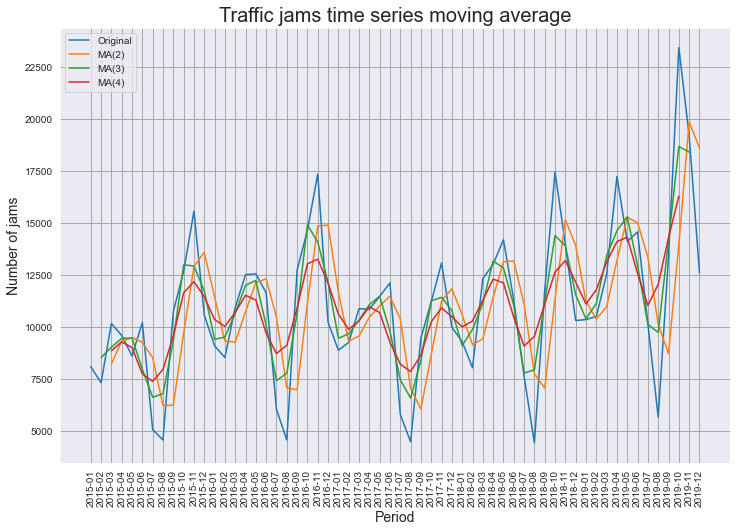

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

sns.lineplot(data=traffic_jams_df.reset_index(), x='index', y="n_jams", ax=ax, color='C0')
sns.lineplot(data=single_ma2_df.reset_index(), x='index', y="MA(2)", ax=ax, color='C1')
sns.lineplot(data=single_ma3_df.reset_index(), x='index', y="MA(3)", ax=ax, color='C2')
sns.lineplot(data=single_ma4_df.reset_index(), x='index', y="MA(4)", ax=ax, color='C3')

ax.set_title('Traffic jams time series moving average', fontsize=20)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)
ax.set_xticklabels(traffic_jams_df.reset_index()['index'], rotation = 90)

ax.legend(labels=['Original', 'MA(2)', 'MA(3)', 'MA(4)'])


fig.savefig('figures/Time_series_single_MA.png')

## Single exponential smoothing

In [16]:
def single_exponential_smoothing(df, y_values_label, alpha):
    """
    Returns the DataFrame with the single exponential smoothing operations.

            Parameters:
                    df (DataFrame): data for the time series
                    y_values (string): label for the column where the time series values are
                    alpha(float): data smoothing factor

            Returns:
                    df (DataFrame): data with the smoothed time series appended.
    """                                 
                                 
    df = df.copy()
    output_col = f'ES({str(alpha)})'
    df[output_col] = ''
    indices = list(df.index)
    # print(indices)
    for i in indices:
        # print(i)
        y = df.at[i, y_values_label]
        if i == indices[0]:
            # Initial value
            s = y
        else:
            # Other calculation
            previous_s = s
            s = (alpha * y) + ((1 - alpha) * previous_s)
        df.at[i, output_col] = s.round(3)
    return df

In [17]:
# Test the function

quarters = []
for year in range(2016, 2019):
    for q in range(1,5):
        quarter = f'{str(year)}-Q{str(q)}'
        quarters.append(quarter)
accidents = [219, 250, 291, 252, 212, 250, 294, 251, 210, 252, 286, 246]
data = {'Quarter': quarters, '# of accidents': accidents}
test_df = pd.DataFrame(data).set_index('Quarter')
single_exponential_smoothing(test_df, '# of accidents', 0.2)

,# of accidents,ES(0.2)
Quarter,,
2016-Q1,219,219
2016-Q2,250,225.2
2016-Q3,291,238.36
2016-Q4,252,241.088
2017-Q1,212,235.27
2017-Q2,250,238.216
2017-Q3,294,249.373
2017-Q4,251,249.698
2018-Q1,210,241.759


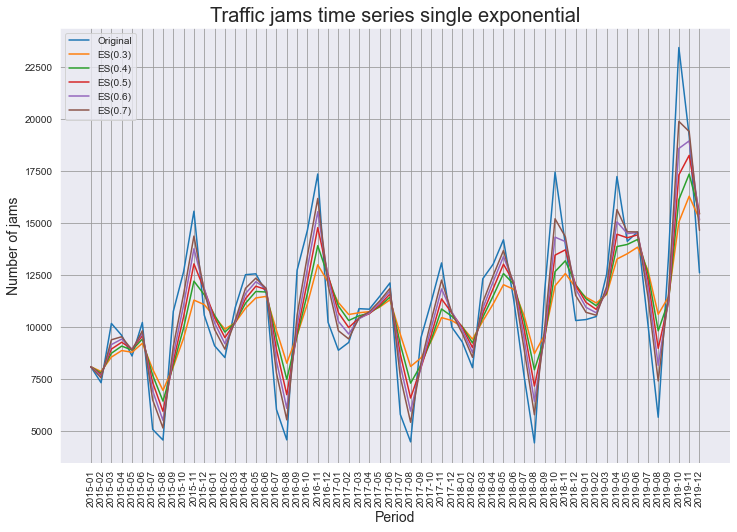

In [18]:
# Calculate the data for various alphas and store it
single_exp_dfs = {}

alphas = [0.3, 0.4, 0.5, 0.6, 0.7]

for alpha in alphas:
    single_exp_df = traffic_jams_df.copy()
    result_df = single_exponential_smoothing(single_exp_df, 'n_jams', alpha)
    result_df.to_csv(f'processed/single_exp({str(alpha)}).csv')
    single_exp_dfs[alpha] = result_df

    
# Make a figure for all alphas and original

fig, ax = plt.subplots(1, 1, figsize=(12,8))

sns.lineplot(data=traffic_jams_df.reset_index(), x='index', y="n_jams", ax=ax, color='C0')
legend_labels = ['Original']
for alpha in alphas:
    color_i = alphas.index(alpha) + 1
    sns.lineplot(data=single_exp_dfs[alpha].reset_index(), x='index', y=f'ES({str(alpha)})', ax=ax, color=f'C{str(color_i)}')
    legend_labels.append(f'ES({str(alpha)})')

ax.set_title('Traffic jams time series single exponential', fontsize=20)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)
ax.set_xticklabels(traffic_jams_df.reset_index()['index'], rotation = 90)

ax.legend(labels=legend_labels)


fig.savefig('figures/Time_series_single_exp.png')

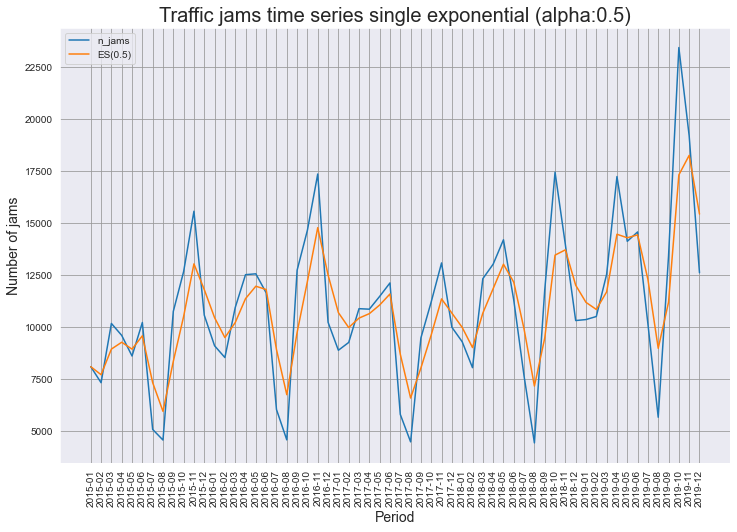

In [27]:
alpha = 0.5

single_exp_df = traffic_jams_df.copy()
result_df = single_exponential_smoothing(single_exp_df, 'n_jams', alpha)
result_df.to_csv(f'processed/single_exp({str(alpha)}).csv')

fig, ax = plt.subplots(1, 1, figsize=(12,8))

columns_left = ['n_jams', f'ES({str(alpha)})']

for column in columns_left:
    color_i = columns_left.index(column)
    sns.lineplot(data=result_df.reset_index(), x='index', y=column, ax=ax, color=f'C{str(color_i)}')
    
# fig.suptitle(f'Traffic jams time series triple exponential (alpha:{alpha})', fontsize=20)
ax.set_title(f'Traffic jams time series single exponential (alpha:{alpha})', fontsize=20)

ax.set_xlabel('Period', fontsize=14)
    
ax.set_xticklabels(result_df.reset_index()['index'], rotation = 90)

ax.legend(labels=columns_left)
ax.set_ylabel('Number of jams', fontsize=14)


fig.savefig(f'figures/Time_series_single_exp_single_{alpha}.png')

## Double exponential smoothing

In [20]:
def double_exponential_smoothing(df, y_values_label, alpha, beta):
    """
    Returns the DataFrame with the single exponential smoothing operations.

            Parameters:
                    df (DataFrame): data for the time series
                    y_values (string): label for the column where the time series values are
                    alpha(float): data smoothing factor
                    beta(float): trend smoothing factor

            Returns:
                    df (DataFrame): data with the smoothed time series appended.
    """                                 
                                 
    df = df.copy()
    output_col = f'ES({str(alpha)}, {str(beta)})'
    trend_col = 'bt'
    df[trend_col] = ''
    df[output_col] = ''
    indices = list(df.index)
    # print(indices)
    for i in indices:
        # print(i)
        y = df.at[i, y_values_label]
        if i == indices[0]:
            # Initial value
            s = y
            next_y = df.at[indices[1], y_values_label]
            b = next_y - y
        else:
            # Other calculation
            previous_s = s
            previous_b = b
            s = (alpha * y) + ((1 - alpha) * (previous_s + previous_b))
            b = (beta * (s - previous_s)) + ((1 - beta) * previous_b)
        
        df.at[i, trend_col] = b.round(3)
        df.at[i, output_col] = s.round(3)
    
    return df

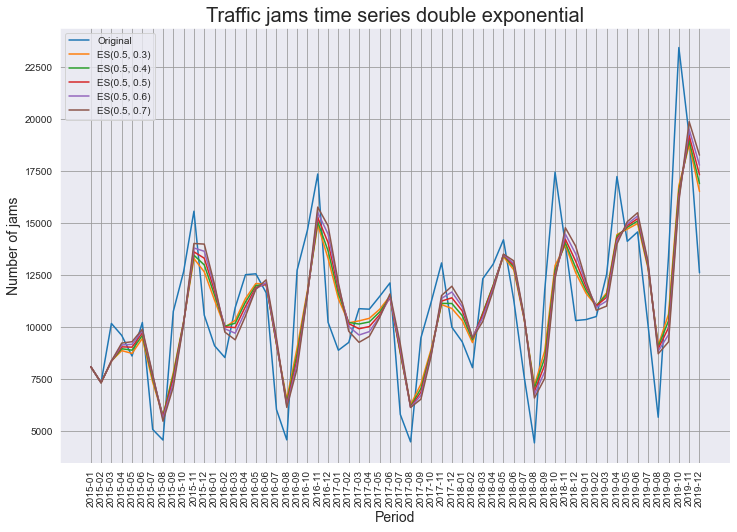

In [21]:
# Calculate the data for various betas and store it
double_exp_dfs = {}
alpha = 0.5
betas = [0.3, 0.4, 0.5, 0.6, 0.7]

for beta in betas:
    double_exp_df = traffic_jams_df.copy()
    result_df = double_exponential_smoothing(double_exp_df, 'n_jams', alpha, beta)
    result_df.to_csv(f'processed/double_exp({str(alpha)}, {str(beta)}).csv')
    double_exp_dfs[beta] = result_df

    
# Make a figure for all betas and original

fig, ax = plt.subplots(1, 1, figsize=(12,8))

sns.lineplot(data=traffic_jams_df.reset_index(), x='index', y="n_jams", ax=ax, color='C0')
legend_labels = ['Original']
for beta in betas:
    color_i = betas.index(beta) + 1
    sns.lineplot(data=double_exp_dfs[beta].reset_index(), x='index', y=f'ES({str(alpha)}, {str(beta)})', ax=ax, color=f'C{str(color_i)}')
    legend_labels.append(f'ES({str(alpha)}, {str(beta)})')

ax.set_title('Traffic jams time series double exponential', fontsize=20)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)
ax.set_xticklabels(traffic_jams_df.reset_index()['index'], rotation = 90)

ax.legend(labels=legend_labels)


fig.savefig('figures/Time_series_double_exp.png')

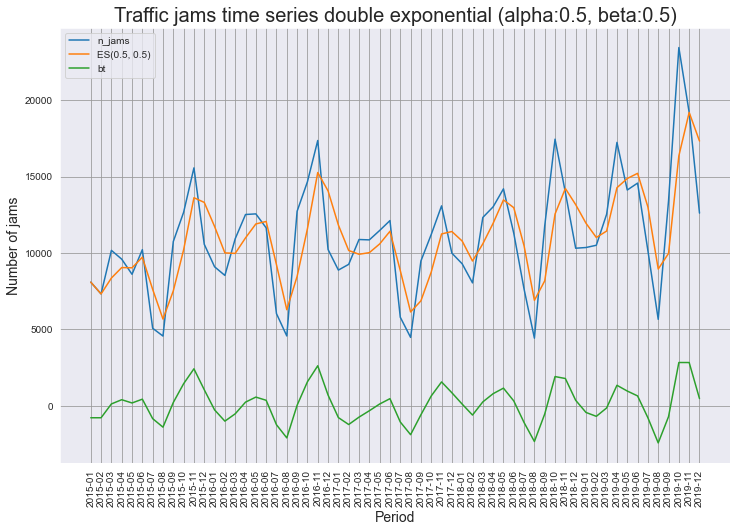

In [28]:
alpha = 0.5
beta = 0.5

double_exp_df = traffic_jams_df.copy()
result_df = double_exponential_smoothing(double_exp_df, 'n_jams', alpha, beta)
result_df.to_csv(f'processed/double_exp({str(alpha)}, {str(beta)}).csv')

fig, ax = plt.subplots(1, 1, figsize=(12,8))

columns_left = ['n_jams', f'ES({str(alpha)}, {str(beta)})', 'bt']

for column in columns_left:
    color_i = columns_left.index(column)
    sns.lineplot(data=result_df.reset_index(), x='index', y=column, ax=ax, color=f'C{str(color_i)}')
    
# fig.suptitle(f'Traffic jams time series triple exponential (alpha:{alpha}, beta:{beta})', fontsize=20)
ax.set_title(f'Traffic jams time series double exponential (alpha:{alpha}, beta:{beta})', fontsize=20)

ax.set_xlabel('Period', fontsize=14)
    
ax.set_xticklabels(result_df.reset_index()['index'], rotation = 90)

ax.legend(labels=columns_left)
ax.set_ylabel('Number of jams', fontsize=14)


fig.savefig(f'figures/Time_series_double_exp_single_{alpha}_{beta}.png')

## Triple exponential smoothing

In [23]:
def triple_exponential_smoothing(df, y_values_label, alpha, beta, gamma, L, periods_label):
    """
    Returns the DataFrame with the single exponential smoothing operations.

            Parameters:
                    df (DataFrame): data for the time series
                    y_values_label(str): label for the column where the time series values are
                    alpha(float): data smoothing factor
                    beta(float): trend smoothing factor
                    gamma(float): seasonal change smoothing factor
                    L(int): length of the season in periods
                    periods_label(str): label for the column where the repeating periods in a season are

            Returns:
                    df (DataFrame): data with the smoothed time series appended.
    """                                 
                                 
    df = df.copy()

    #c_list = []

    output_col = f'ES({str(alpha)}, {str(beta)}, {str(gamma)})'
    trend_col = 'bt'
    season_col = 'ct'
    df[trend_col] = ''
    df[season_col] = ''
    df[output_col] = ''
    indices = list(df.index)
    
    periods = list(df[periods_label].unique())
    
    # Initial seasonality calculations
    avg_first_season = sum([df.at[indices[i], y_values_label] for i in range(L)]) / L
    N = df.shape[0] // L # number of complete seasons in the data

    
    for i in indices:
        y = df.at[i, y_values_label]
        
        if i == indices[0]:
            # Initial values
            indices_period = [indices[indices.index(i)+(season * L)] for season in range(N)]
            xs_for_period = [df.at[period, y_values_label] for period in indices_period]
            proportion_x_for_period = [x / avg_first_season for x in xs_for_period]
            ct = sum(proportion_x_for_period) / N
            
            s = y
            
            this_season_periods = [indices[period] for period in range(L)]
            next_season_periods = [indices[period + L] for period in range(L)]
            this_season_y = [df.at[period, y_values_label] for period in this_season_periods]
            next_season_y = [df.at[period, y_values_label] for period in next_season_periods]
            b = sum([(next_season_y[period] - this_season_y[period]) / L for period in range(L)]) / L
            
        
        elif indices.index(i) < L:
            
            # Initial values
            indices_period = [indices[indices.index(i)+(season * L)] for season in range(N)]
            xs_for_period = [df.at[period, y_values_label] for period in indices_period]
            proportion_x_for_period = [x / avg_first_season for x in xs_for_period]
            ct = sum(proportion_x_for_period) / N
            
            s = y
            
            previous_s = s
            previous_b = b
            b = (beta * (s - previous_s)) + ((1 - beta) * previous_b)
        else:
            previous_season_i = indices[indices.index(i) - L]
            previous_season_ct = df.at[previous_season_i, season_col]
            ct = (gamma * y / s) + ((1 - gamma) * previous_season_ct) # only if initial
        
#         if i == indices[0]:
#             # Initial value
#             s = y
#             this_season_periods = [indices[period] for period in range(L)]
#             next_season_periods = [indices[period + L] for period in range(L)]
#             this_season_y = [df.at[period, y_values_label] for period in this_season_periods]
#             next_season_y = [df.at[period, y_values_label] for period in next_season_periods]
#             b = sum([(next_season_y[period] - this_season_y[period]) / L for period in range(L)]) / L
#         else:
            # Other calculation
            previous_s = s
            previous_b = b
            s = (alpha * y / previous_season_ct) + ((1 - alpha) * (previous_s + previous_b))
            b = (beta * (s - previous_s)) + ((1 - beta) * previous_b)

        
        df.at[i, trend_col] = b.round(3)
        df.at[i, output_col] = s.round(3)
        df.at[i, season_col] = ct
        
    df[season_col] = df[season_col].apply(lambda x: x.round(3))
    
    return df

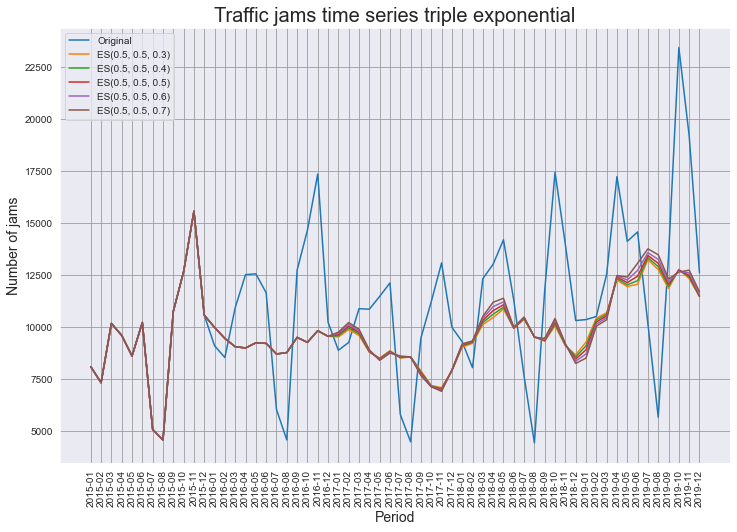

In [24]:
# Calculate the data for various gammas and store it
triple_exp_dfs = {}
alpha = 0.5
beta = 0.5
gammas = [0.3, 0.4, 0.5, 0.6, 0.7]

for gamma in gammas:
    triple_exp_df = traffic_jams_df.copy()
    result_df = triple_exponential_smoothing(triple_exp_df, 'n_jams', alpha, beta, gamma, 12, 'month')
    result_df.to_csv(f'processed/triple_exp({str(alpha)}, {str(beta)}, {str(gamma)}).csv')
    triple_exp_dfs[gamma] = result_df

    
# Make a figure for all betas and original

fig, ax = plt.subplots(1, 1, figsize=(12,8))

sns.lineplot(data=traffic_jams_df.reset_index(), x='index', y="n_jams", ax=ax, color='C0')
legend_labels = ['Original']
for gamma in gammas:
    color_i = gammas.index(gamma) + 1
    sns.lineplot(data=triple_exp_dfs[gamma].reset_index(), x='index', y=f'ES({str(alpha)}, {str(beta)}, {str(gamma)})', ax=ax, color=f'C{str(color_i)}')
    legend_labels.append(f'ES({str(alpha)}, {str(beta)}, {str(gamma)})')

ax.set_title('Traffic jams time series triple exponential', fontsize=20)
ax.set_xlabel('Period', fontsize=14)
ax.set_ylabel('Number of jams', fontsize=14)
ax.set_xticklabels(traffic_jams_df.reset_index()['index'], rotation = 90)

ax.legend(labels=legend_labels)


fig.savefig('figures/Time_series_triple_exp.png')

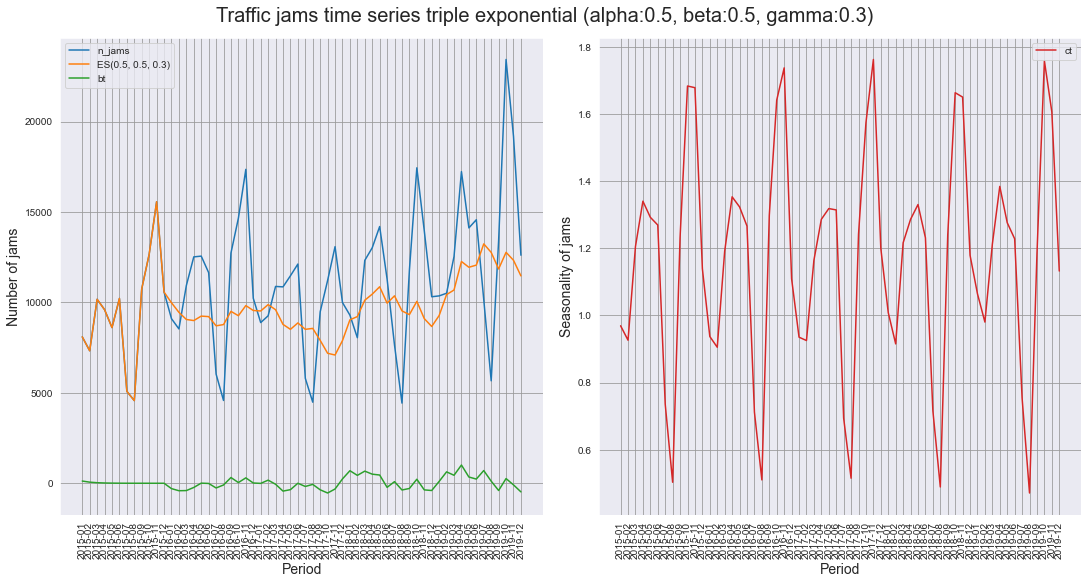

In [29]:
alpha = 0.5
beta = 0.5
gamma = 0.3

triple_exp_df = traffic_jams_df.copy()
result_df = triple_exponential_smoothing(triple_exp_df, 'n_jams', alpha, beta, gamma, 12, 'month')
result_df.to_csv(f'processed/triple_exp({str(alpha)}, {str(beta)}, {str(gamma)}).csv')

fig, axs = plt.subplots(1, 2, figsize=(15,8), constrained_layout=True)

columns_left = ['n_jams', f'ES({str(alpha)}, {str(beta)}, {str(gamma)})', 'bt']
columns_right = ['ct']
legend_labels = []
for column in columns_left:
    color_i = columns_left.index(column)
    sns.lineplot(data=result_df.reset_index(), x='index', y=column, ax=axs[0], color=f'C{str(color_i)}')
    
for column in columns_right:
    color_i = columns_right.index(column) + len(columns_left)
    sns.lineplot(data=result_df.reset_index(), x='index', y=column, ax=axs[1], color=f'C{str(color_i)}')
fig.suptitle(f'Traffic jams time series triple exponential (alpha:{alpha}, beta:{beta}, gamma:{gamma})', fontsize=20)
#ax.set_title('Traffic jams time series triple exponential', fontsize=20)
for ax in axs:
    ax.set_xlabel('Period', fontsize=14)
    
    ax.set_xticklabels(result_df.reset_index()['index'], rotation = 90)

axs[0].legend(labels=columns_left)
axs[0].set_ylabel('Number of jams', fontsize=14)
axs[1].legend(labels=columns_right)
axs[1].set_ylabel('Seasonality of jams', fontsize=14)


fig.savefig(f'figures/Time_series_triple_exp_single_{alpha}_{beta}_{gamma}.png')

In [26]:
alpha = 0.5
beta = 0.5
gamma = 0.5

triple_exp_df = traffic_jams_df.copy()
triple_exponential_smoothing(double_exp_df, 'n_jams', alpha, beta, gamma, 12, 'month')

,year,month,n_jams,bt,ct,"ES(0.5, 0.5, 0.5)"
2015-01,2015,01,8095,122.625,0.969,8095
2015-02,2015,02,7325,61.312,0.926,7325
2015-03,2015,03,10172,30.656,1.205,10172
2015-04,2015,04,9598,15.328,1.340,9598
2015-05,2015,05,8608,7.664,1.292,8608
2015-06,2015,06,10218,3.832,1.269,10218
2015-07,2015,07,5080,1.916,0.736,5080
2015-08,2015,08,4570,0.958,0.503,4570
2015-09,2015,09,10751,0.479,1.232,10751
2015-10,2015,10,12661,0.24,1.683,12661
